In [2]:
import pandas as pd

# Load the dataset
file_path = '/user/HS400/dd00830/Downloads/Dissertation/Dataset.csv'  
dataset = pd.read_csv(file_path)

# Drop rows with missing values in 'selftext' and 'Label' columns
dataset_clean = dataset.dropna(subset=['selftext', 'Label'])

# Display the cleaned dataset
dataset_clean.head()


,score,selftext,subreddit,title,Label,CAT 1
0,1.0,Tried to watch this documentary “anxious Ameri...,Anxiety,Do people get over anxiety?,Drug and Alcohol,NaN
1,1.0,"i’m currently laying in bed wide awake, feelin...",Anxiety,does anyone else have this big fear of suddenl...,Drug and Alcohol,NaN
2,2.0,Second time trying weed. First time felt close...,Anxiety,3 hour long panic attack after trying weed,Drug and Alcohol,NaN
3,1.0,"I am not posting this for me, but rather for m...",Anxiety,Please leave in the comments ANYTHING that has...,Drug and Alcohol,NaN
4,1.0,21 year old male been dealing with anxiety eve...,Anxiety,Alcohol induced,Drug and Alcohol,NaN


In [3]:
# Text preprocessing function
def preprocess_text(text):
    text = text.lower()  # Lowercasing
    text = text.replace('\n', ' ')  # Replace newlines with spaces
    text = ''.join([c for c in text if c.isalnum() or c.isspace()])  # Remove special characters
    return text

# Apply text preprocessing to 'selftext'
dataset_clean['selftext'] = dataset_clean['selftext'].apply(preprocess_text)

# Display the preprocessed text
dataset_clean[['selftext', 'Label']].head()


/tmp/ipykernel_52177/4104052476.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_clean['selftext'] = dataset_clean['selftext'].apply(preprocess_text)


,selftext,Label
0,tried to watch this documentary anxious americ...,Drug and Alcohol
1,im currently laying in bed wide awake feeling ...,Drug and Alcohol
2,second time trying weed first time felt close ...,Drug and Alcohol
3,i am not posting this for me but rather for my...,Drug and Alcohol
4,21 year old male been dealing with anxiety eve...,Drug and Alcohol


In [4]:
# Normalize labels to lowercase
dataset_clean['Label'] = dataset_clean['Label'].str.lower().str.strip()

# Map labels to integers after normalization
label_map = {label: idx for idx, label in enumerate(dataset_clean['Label'].unique())}
dataset_clean['Label'] = dataset_clean['Label'].map(label_map)

# Display the label mapping
label_map


/tmp/ipykernel_52177/3517559097.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_clean['Label'] = dataset_clean['Label'].str.lower().str.strip()
/tmp/ipykernel_52177/3517559097.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_clean['Label'] = dataset_clean['Label'].map(label_map)


{'drug and alcohol': 0,
 'early life': 1,
 'personality': 2,
 'trauma and stress': 3}

In [5]:
from transformers import BertTokenizer

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the 'selftext' data
tokenized_inputs = dataset_clean['selftext'].apply(
    lambda x: tokenizer(x, truncation=True, padding='max_length', max_length=128)
)

# Display the tokenized inputs
tokenized_inputs.head()


0    [input_ids, token_type_ids, attention_mask]
1    [input_ids, token_type_ids, attention_mask]
2    [input_ids, token_type_ids, attention_mask]
3    [input_ids, token_type_ids, attention_mask]
4    [input_ids, token_type_ids, attention_mask]
Name: selftext, dtype: object

In [6]:
from datasets import Dataset

# Convert to a Hugging Face Dataset
dataset = Dataset.from_pandas(pd.DataFrame({
    'input_ids': [x['input_ids'] for x in tokenized_inputs],
    'attention_mask': [x['attention_mask'] for x in tokenized_inputs],
    'labels': dataset_clean['Label'].tolist()  # Ensure this is named 'labels'
}))

# Split the dataset into training and testing sets
train_dataset, test_dataset = dataset.train_test_split(test_size=0.2).values()

# Display the sizes of the datasets
len(train_dataset), len(test_dataset)


(640, 160)

In [7]:
from transformers import BertForSequenceClassification

# Initialize the BERT Model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_map))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
from transformers import TrainingArguments

# Define Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,                # Number of training epochs
    per_device_train_batch_size=8,     # Batch size for training
    per_device_eval_batch_size=8,      # Batch size for evaluation
    warmup_steps=500,                  # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,                 # Strength of weight decay
    logging_dir='./logs',              # Directory for storing logs
    logging_steps=10,                  # Log every X updates steps
    evaluation_strategy="epoch"        # Evaluate at the end of each epoch
)


In [9]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Define Compute Metrics Function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


In [10]:
from transformers import Trainer

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,       # The dataset for training with 'labels'
    eval_dataset=test_dataset,         # The dataset for evaluation with 'labels'
    compute_metrics=compute_metrics
)

# Start Training
trainer.train()


2024-09-02 01:14:52.667306: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-02 01:15:27.548364: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.392900,1.369321,0.281250,0.169952,0.167187,0.281250
2,1.209700,1.142301,0.612500,0.565617,0.638567,0.612500
3,0.786300,0.790460,0.700000,0.655769,0.731950,0.700000
4,0.601200,0.711580,0.737500,0.735287,0.751316,0.737500
5,0.396300,0.983061,0.693750,0.680045,0.702226,0.693750
6,0.211800,1.144792,0.762500,0.755101,0.761613,0.762500
7,0.065500,1.149452,0.731250,0.722529,0.721671,0.731250
8,0.065900,1.351964,0.756250,0.754075,0.757740,0.756250
9,0.003300,1.442459,0.768750,0.766893,0.766776,0.768750
10,0.061000,1.429721,0.762500,0.760166,0.758864,0.762500


TrainOutput(global_step=800, training_loss=0.5276467365992721, metrics={'train_runtime': 253.6128, 'train_samples_per_second': 25.235, 'train_steps_per_second': 3.154, 'total_flos': 420985248153600.0, 'train_loss': 0.5276467365992721, 'epoch': 10.0})

In [11]:
# Evaluate the Model
eval_result = trainer.evaluate()

# Display Evaluation Results
print("Evaluation Results:")
print(f"Accuracy: {eval_result['eval_accuracy']:.4f}")
print(f"Precision: {eval_result['eval_precision']:.4f}")
print(f"Recall: {eval_result['eval_recall']:.4f}")
print(f"F1 Score: {eval_result['eval_f1']:.4f}")


Evaluation Results:
Accuracy: 0.7625
Precision: 0.7589
Recall: 0.7625
F1 Score: 0.7602


In [12]:
# Evaluate the model
evaluation_metrics = trainer.evaluate()

print(f"Validation Accuracy: {evaluation_metrics['eval_accuracy']:.4f}")
print(f"Validation Loss: {evaluation_metrics['eval_loss']:.4f}")


Validation Accuracy: 0.7625
Validation Loss: 1.4297


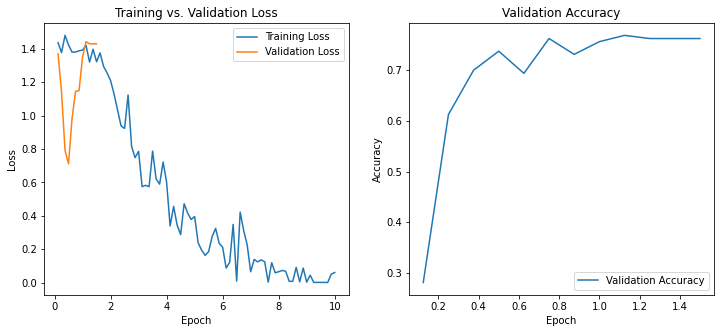

In [13]:
import matplotlib.pyplot as plt

# Extract loss and accuracy from log history for plotting
epochs = []
train_loss = []
eval_loss = []
train_accuracy = []
eval_accuracy = []

for log in trainer.state.log_history:
    if 'loss' in log and 'epoch' in log:
        epochs.append(log['epoch'])
        train_loss.append(log['loss'])
    if 'eval_loss' in log:
        eval_loss.append(log['eval_loss'])
    if 'eval_accuracy' in log:
        eval_accuracy.append(log['eval_accuracy'])

# Plotting loss and accuracy
plt.figure(figsize=(12, 5))

# Plotting loss
plt.subplot(1, 2, 1)
plt.plot(epochs[:len(train_loss)], train_loss, label='Training Loss')
plt.plot(epochs[:len(eval_loss)], eval_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs[:len(eval_accuracy)], eval_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.show()


In [14]:
# Get predictions on the test dataset
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(-1)
true_labels = predictions.label_ids


In [15]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(true_labels, preds, target_names=list(label_map.keys()))
print("Classification Report:")
print(report)


Classification Report:
                   precision    recall  f1-score   support

 drug and alcohol       0.85      0.91      0.88        44
       early life       0.84      0.84      0.84        38
      personality       0.68      0.68      0.68        40
trauma and stress       0.66      0.61      0.63        38

         accuracy                           0.76       160
        macro avg       0.76      0.76      0.76       160
     weighted avg       0.76      0.76      0.76       160



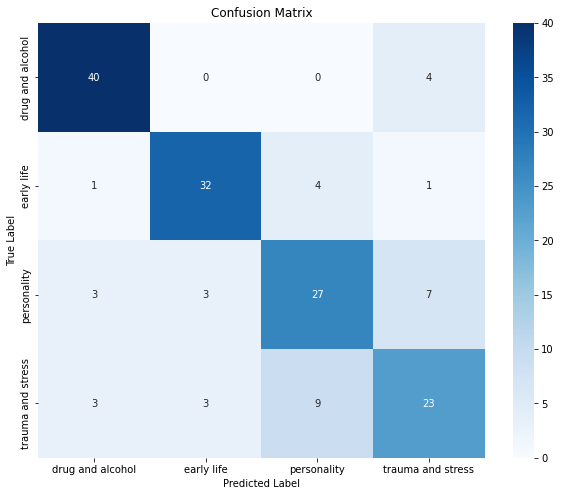

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(true_labels, preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_map.keys()), yticklabels=list(label_map.keys()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


## HYPERPARAMETER TUNING:-


In [17]:
pip install optuna


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [18]:
import optuna
from transformers import Trainer, TrainingArguments

def model_init():
    return BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_map))

def hp_search(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 2, 6),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),
        "weight_decay": trial.suggest_float("weight_decay", 0.01, 0.3)
    }

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
    do_train=True,
    do_eval=True,
)

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

best_run = trainer.hyperparameter_search(
    direction="maximize",
    backend="optuna",
    hp_space=hp_search,
    n_trials=10
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2024-09-02 01:30:36,668] A new study created in memory with name: no-name-b9124ea3-0d2e-4e97-a71a-c28f22b0c65c
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.391800,1.390563,0.243750,0.182419,0.197780,0.243750
2,1.360500,1.374971,0.300000,0.282311,0.277741,0.300000


[I 2024-09-02 01:31:14,470] Trial 0 finished with value: 1.1600518680485332 and parameters: {'learning_rate': 1.8544216043100707e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 32, 'weight_decay': 0.08041443465880166}. Best is trial 0 with value: 1.1600518680485332.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.385100,1.355036,0.350000,0.293271,0.349003,0.350000
2,1.193700,1.186485,0.525000,0.489096,0.515332,0.525000
3,1.060600,1.082795,0.575000,0.550447,0.556532,0.575000


[I 2024-09-02 01:32:16,573] Trial 1 finished with value: 2.256979431792063 and parameters: {'learning_rate': 1.784419369671113e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'weight_decay': 0.02456501936484788}. Best is trial 1 with value: 2.256979431792063.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.244600,1.213131,0.425000,0.337009,0.319609,0.425000
2,0.976300,0.938436,0.718750,0.709803,0.709385,0.718750


/user/HS400/dd00830/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-09-02 01:33:05,028] Trial 2 finished with value: 2.85668824218875 and parameters: {'learning_rate': 2.346750711993078e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 8, 'weight_decay': 0.23976240965409512}. Best is trial 2 with value: 2.85668824218875.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.134200,1.076990,0.562500,0.495982,0.544755,0.562500
2,0.690700,0.683654,0.706250,0.702426,0.702466,0.706250
3,0.451500,0.817882,0.700000,0.675075,0.800933,0.700000
4,0.286100,0.863635,0.743750,0.741963,0.741871,0.743750
5,0.110400,0.976014,0.743750,0.742308,0.741332,0.743750
6,0.090800,1.021490,0.750000,0.749201,0.749404,0.750000


[I 2024-09-02 01:35:28,617] Trial 3 finished with value: 2.9986042565956117 and parameters: {'learning_rate': 2.8239956063382995e-05, 'num_train_epochs': 6, 'per_device_train_batch_size': 8, 'weight_decay': 0.11697265685064687}. Best is trial 3 with value: 2.9986042565956117.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.381200,1.362010,0.306250,0.231936,0.286039,0.306250
2,1.263000,1.290186,0.550000,0.531658,0.570749,0.550000


/user/HS400/dd00830/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-09-02 01:36:06,281] Trial 4 finished with value: 2.2024076577429197 and parameters: {'learning_rate': 3.9037549315115997e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 32, 'weight_decay': 0.18072052958199605}. Best is trial 3 with value: 2.9986042565956117.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.159400,1.109821,0.493750,0.420985,0.367258,0.493750


/user/HS400/dd00830/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-09-02 01:36:30,726] Trial 5 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.341800,1.344067,0.325000,0.220162,0.286506,0.325000


[I 2024-09-02 01:36:55,088] Trial 6 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.110800,1.050894,0.600000,0.552109,0.557991,0.600000
2,0.693900,0.682454,0.743750,0.738940,0.746733,0.743750
3,0.391100,0.621227,0.781250,0.780113,0.784373,0.781250


[I 2024-09-02 01:38:07,077] Trial 7 finished with value: 3.1269859236476476 and parameters: {'learning_rate': 4.465967058613261e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 8, 'weight_decay': 0.10772097257846291}. Best is trial 7 with value: 3.1269859236476476.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.334100,1.324580,0.381250,0.310880,0.398409,0.381250


[I 2024-09-02 01:38:31,386] Trial 8 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.390900,1.377086,0.368750,0.282773,0.277851,0.368750
2,1.304200,1.284767,0.481250,0.468436,0.526840,0.481250
3,1.132400,1.124293,0.568750,0.562734,0.566334,0.568750
4,0.962000,0.990940,0.637500,0.630642,0.637149,0.637500
5,0.879200,0.935604,0.675000,0.674612,0.674332,0.675000


/user/HS400/dd00830/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-09-02 01:40:04,557] Trial 9 finished with value: 2.6989441913823935 and parameters: {'learning_rate': 2.5979260862561525e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 32, 'weight_decay': 0.16833866077797854}. Best is trial 7 with value: 3.1269859236476476.


In [19]:
print("Best Hyperparameters:", best_run)


Best Hyperparameters: BestRun(run_id='7', objective=3.1269859236476476, hyperparameters={'learning_rate': 4.465967058613261e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 8, 'weight_decay': 0.10772097257846291}, run_summary=None)


## BEST HYPER PARAMETER:-


In [20]:
best_learning_rate = best_run.hyperparameters['learning_rate']
best_num_train_epochs = best_run.hyperparameters['num_train_epochs']
best_batch_size = best_run.hyperparameters['per_device_train_batch_size']
best_weight_decay = best_run.hyperparameters['weight_decay']

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=best_learning_rate,
    num_train_epochs=best_num_train_epochs,
    per_device_train_batch_size=best_batch_size,
    weight_decay=best_weight_decay,
    logging_dir='./logs',
    logging_steps=10,
)

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Train with the best hyperparameters
trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.110800,1.050894,0.600000,0.552109,0.557991,0.600000
2,0.693900,0.682454,0.743750,0.738940,0.746733,0.743750
3,0.391100,0.621227,0.781250,0.780113,0.784373,0.781250


TrainOutput(global_step=240, training_loss=0.8714175194501876, metrics={'train_runtime': 71.7577, 'train_samples_per_second': 26.757, 'train_steps_per_second': 3.345, 'total_flos': 126295574446080.0, 'train_loss': 0.8714175194501876, 'epoch': 3.0})

In [21]:
# Evaluate the model on the test dataset
eval_result = trainer.evaluate()

# Display evaluation results
print("Evaluation Results:")
print(f"Accuracy: {eval_result['eval_accuracy']:.4f}")
print(f"Precision: {eval_result['eval_precision']:.4f}")
print(f"Recall: {eval_result['eval_recall']:.4f}")
print(f"F1 Score: {eval_result['eval_f1']:.4f}")


Evaluation Results:
Accuracy: 0.7812
Precision: 0.7844
Recall: 0.7812
F1 Score: 0.7801


Classification Report:
                   precision    recall  f1-score   support

 drug and alcohol       0.91      0.91      0.91        44
       early life       0.87      0.87      0.87        38
      personality       0.64      0.75      0.69        40
trauma and stress       0.71      0.58      0.64        38

         accuracy                           0.78       160
        macro avg       0.78      0.78      0.78       160
     weighted avg       0.78      0.78      0.78       160

<function confusion_matrix at 0x7fa7d4646c20>


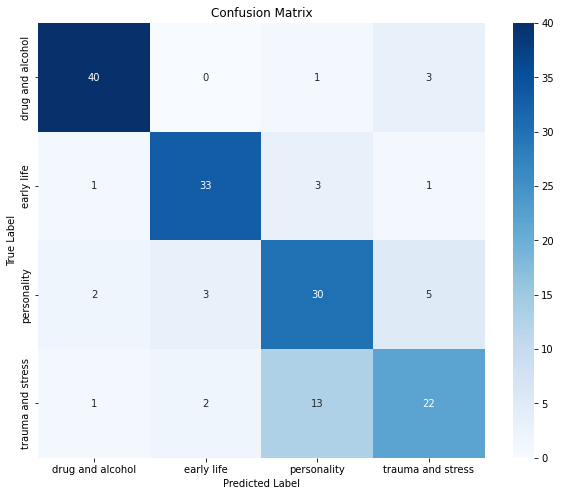

In [23]:
# Get predictions on the test dataset
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(-1)
true_labels = predictions.label_ids

# Generate and display classification report
from sklearn.metrics import classification_report

report = classification_report(true_labels, preds, target_names=list(label_map.keys()))
print("Classification Report:")
print(report)

# Generate and display confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, preds)
print(confusion_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_map.keys()), yticklabels=list(label_map.keys()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
